In [768]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [769]:
# load data

table_path = "data/df_july.csv"
df = pd.read_csv(table_path)
print(df.shape)
df.isnull().sum()

(1754466, 26)


city                                0
bar_id                              0
order_id                            0
order_time                          0
order_item_id                       0
title                               0
category_id                     36212
beer_brand_id                       0
beer_serving_type_id                0
beer_volume                      2546
item_qty                            0
sales_before_tax                    0
sales_inc_tax                       0
guest_count                         0
waiter_id                        5545
country                             0
country_id                          0
state                               0
state_id                            0
timezone                            0
bar_type_id                         0
status                              0
last_status                         0
is_bulk                             0
bar_type                       155782
data_availability_status_id         0
dtype: int64

### cleaning null values
###  + new features: total_orders, total_orders_category_id

In [770]:
data = df.copy()
data = data.dropna()

# total orders
data["total_orders"] = data.groupby("order_id")["order_id"].transform("size")

data = pd.concat([data, pd.get_dummies(data["category_id"], prefix="category_id")], axis=1)

# total orders by category
category_ids = [float(i) for i in range(1, 7)]
for category_id in category_ids:
    data["total_orders_category_id_" + str(category_id)] =\
        data.groupby("order_id")["category_id_" + str(category_id)].transform("sum")


one_hot_encoded = ["category_id_" + str(category_id) for category_id in category_ids]
data.drop(one_hot_encoded, axis=1, inplace=True)

In [771]:
# drop unrelevant titles
def filter_titles(title):
    if "extra" in title:
        return False
    elif "add" in title:
        return False
    elif "sauce" in title:
        return False
    elif "no " in title:
        return False
    elif "no." in title:
        return False
    elif "-no " in title:
        return False
    elif "side " in title:
        return False
    elif "+" in title:
        return False
    elif "dip" in title:
        return False
    elif "blue cheese" in title:
        return False
    elif "bbq" in title:
        return False
    elif "n/c" in title:
        return False
    elif "s/o" in title:
        return False
    elif title == '' or title == 'garlic.aioli' or title == 'gluten' or title == 'hot n honey' or title == 'honey garlic' or title == 'kids.' or title == 'to go':
        return False
    else:
        return True

data['order_time'] = pd.to_datetime(data['order_time'], format='%Y-%m-%d %H:%M:%S.%f')

# remove unnecessary characters from title
whitelist = set('.abcdefghijklmnopqrstuvwxyz \\//')
data["title"] = data["title"].apply(lambda x: ''.join(filter(whitelist.__contains__ ,x.lower())))
data = data[~((data['title'].map(filter_titles) == False))]

### + kids_meal
### + birthday

In [772]:
# meal with kids
data["kids_meal"] = data.title.apply(lambda x: 1 if 'kid' in x else 0)
# birthday
data["birthday"] = data.title.apply(lambda x: 1 if 'birthday' in x else 0)

### on all(!) cities

In [773]:
# only 83 rows from Night Club
data = data[data["bar_type"] != "Night Club"] 
# choose only Toronto city
# data = data.loc[df.city == "Toronto"] 
data.drop(["data_availability_status_id", "city", "is_bulk", "status", "last_status", "state", 
           "state_id", "waiter_id", "country_id", "title", "timezone", "order_item_id", 
           "beer_brand_id", "beer_serving_type_id", "item_qty", 
           "sales_before_tax", "country"],axis=1,inplace=True)

In [774]:
# one hot - bar type
data = pd.concat([data, pd.get_dummies(data["bar_type"], prefix="bar_type")], axis=1)

In [775]:
data.rename(columns={'bar_type_Casual Dining':'bar_type_casual_dining', 'bar_type_Bar/Pub':'bar_type_bar_pub', 'bar_type_Restaurant':'bar_type_restaurant', 'bar_type_Casual Bar':'bar_type_casual_bar',
       'bar_type_Beer Bar / Pub':'bar_type_beer_bar_pub', 'bar_type_Trendy Bar':'bar_type_trendy_bar', 'bar_type_Club - Sports':'bar_type_club_sports',
       'bar_type_Trendy Restaurant':'bar_type_trendy_restaurant', 'bar_type_Hotel':'bar_type_hotel', 'bar_type_Fine Dining':'bar_type_fine_dining',
       'bar_type_Restaurante informal':'bar_type_restaurante_informal', 'bar_type_Sports Bar':'bar_type_sports_bar', 'bar_type_Pizzería/Restaurante':'bar_type_pizzería_restaurante',
       'bar_type_Trendy Bar/Pub':'bar_type_trendy_bar_pub', 'bar_type_Party POC':'bar_type_party_poc', 'bar_type_Lounge':'bar_type_lounge'}, inplace=True)

In [776]:
# 1 - morning, 2 - afternoon, 3 - evening, 4 - night
def get_part_of_day(hour):
    return (
        1 if 5 <= hour <= 11
        else
        2 if 12 <= hour <= 17
        else
        3 if 18 <= hour <= 22
        else
        4
    )
data['order_time'] = data.order_time.apply(lambda x: get_part_of_day(x.hour))

### drinking habits by hour of day

In [777]:
# 1. beer
# 2. food
# 3. liquer and alcohol
# 4. soft drinks
# 5. side dishes
# 6. cocktails and wine
data.pivot_table(values= "order_id", columns ="category_id", index="order_time",aggfunc="count", fill_value =0)

category_id,1.0,2.0,3.0,4.0,5.0,6.0
order_time,,,,,,
1,9450,62762,4674,21445,23051,1556
2,133022,271491,59797,81925,23733,23333
3,136904,282938,108260,69855,25356,26320
4,22195,22450,37750,4848,2353,1732


### one row per table

In [790]:
data = data.groupby('order_id', as_index=False).agg({'bar_id': "mean", 'order_time':"max", 
'sales_inc_tax':"sum", 'guest_count':"mean",'bar_type_id':"mean", 'total_orders':"mean", 
'total_orders_category_id_1.0':"mean", 'total_orders_category_id_2.0':"mean", 'total_orders_category_id_3.0':"mean",
'total_orders_category_id_4.0':"mean", 'total_orders_category_id_5.0':"mean", 'total_orders_category_id_6.0':"mean",
'kids_meal':"max", 'birthday':"max", 'bar_type_bar_pub':"max", 'bar_type_beer_bar_pub':"max", 
'bar_type_casual_bar':"max", 'bar_type_casual_dining':"max", 'bar_type_club_sports':"max",
'bar_type_fine_dining':"max", 'bar_type_hotel':"max", 'bar_type_lounge':"max", 'bar_type_party_poc':"max", 
'bar_type_pizzería_restaurante':"max", 'bar_type_restaurant':"max", 'bar_type_restaurante_informal':"max", 
'bar_type_sports_bar':"max", 'bar_type_trendy_bar':"max", 'bar_type_trendy_bar_pub':"max", 
'bar_type_trendy_restaurant':"max", 'bar_type':"max", "beer_volume":"sum"})

### + num_drinks

In [797]:
data['num_drinks'] = data['total_orders_category_id_1.0'] + data['total_orders_category_id_3.0'] + data['total_orders_category_id_4.0'] + data['total_orders_category_id_6.0']

In [798]:
grouped_kids = data.loc[grouped.kids_meal == 1]
grouped_birthday = data.loc[grouped.birthday == 1]

### where everybody eat

In [799]:
print(data.bar_type.value_counts(normalize=True))

Bar/Pub                 0.500191
Casual Dining           0.232834
Restaurant              0.077202
Trendy Restaurant       0.064041
Trendy Bar              0.030902
Casual Bar              0.030068
Beer Bar / Pub          0.019915
Hotel                   0.016966
Sports Bar              0.013930
Club - Sports           0.003796
Restaurante informal    0.003259
Fine Dining             0.002293
Pizzería/Restaurante    0.001950
Trendy Bar/Pub          0.001835
Party POC               0.000588
Lounge                  0.000229
Name: bar_type, dtype: float64


In [800]:
data[['order_time', 'sales_inc_tax', 'guest_count','total_orders', 'total_orders_category_id_1.0',
'total_orders_category_id_2.0', 'total_orders_category_id_3.0', 'total_orders_category_id_4.0', 
'total_orders_category_id_5.0', 'total_orders_category_id_6.0','num_drinks']].describe()

,order_time,sales_inc_tax,guest_count,total_orders,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0,num_drinks
count,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000,353759.000000
mean,2.495970,40.197685,1.411243,4.374806,0.854856,2.015064,0.596511,0.505887,0.249509,0.152980,2.108786
std,0.767671,52.189488,5.187471,4.705295,1.788091,2.384413,1.683172,1.170990,1.043818,0.617461,2.997130
min,1.000000,-73.650000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,16.100000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,28.800000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3.000000,50.530000,2.000000,5.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,3.000000
max,4.000000,3576.167999,2670.000000,368.000000,141.000000,105.000000,170.000000,101.000000,63.000000,110.000000,244.000000


### where kids eat

In [801]:
print(grouped_kids.bar_type.value_counts(normalize=True))

Bar/Pub                 0.376197
Casual Dining           0.343687
Trendy Restaurant       0.125544
Restaurant              0.053266
Casual Bar              0.049202
Sports Bar              0.026270
Hotel                   0.015675
Club - Sports           0.004064
Pizzería/Restaurante    0.003338
Trendy Bar              0.002322
Fine Dining             0.000290
Beer Bar / Pub          0.000145
Name: bar_type, dtype: float64


In [802]:
grouped_kids[['order_time', 'sales_inc_tax', 'guest_count','total_orders', 'total_orders_category_id_1.0',
'total_orders_category_id_2.0', 'total_orders_category_id_3.0', 'total_orders_category_id_4.0', 
'total_orders_category_id_5.0', 'total_orders_category_id_6.0','num_drinks']].describe()

,order_time,sales_inc_tax,guest_count,total_orders,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0,num_drinks
count,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000,6890.000000
mean,2.282438,79.103602,2.807837,11.180116,0.727576,6.595646,0.405225,2.650363,0.641364,0.159942,3.943106
std,0.646391,82.244775,2.390332,7.602643,1.433667,4.419888,1.248638,2.541647,1.970858,0.554445,3.594638
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,44.007653,1.000000,6.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,2.000000
50%,2.000000,67.195000,3.000000,10.000000,0.000000,6.000000,0.000000,2.000000,0.000000,0.000000,3.000000
75%,3.000000,94.757684,4.000000,14.000000,1.000000,8.000000,0.000000,4.000000,0.000000,0.000000,5.000000
max,4.000000,3551.022347,41.000000,172.000000,32.000000,88.000000,56.000000,72.000000,37.000000,11.000000,117.000000


### where people celebrate a birthday 

In [803]:
print(grouped_birthday.bar_type.value_counts(normalize=True))

Casual Dining        0.659794
Trendy Restaurant    0.210872
Casual Bar           0.038425
Bar/Pub              0.035614
Sports Bar           0.034677
Beer Bar / Pub       0.020619
Name: bar_type, dtype: float64


In [804]:
grouped_birthday[['order_time', 'sales_inc_tax', 'guest_count','total_orders', 'total_orders_category_id_1.0',
'total_orders_category_id_2.0', 'total_orders_category_id_3.0', 'total_orders_category_id_4.0', 
'total_orders_category_id_5.0', 'total_orders_category_id_6.0','num_drinks']].describe()

,order_time,sales_inc_tax,guest_count,total_orders,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0,num_drinks
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2.561387,87.259942,2.853796,11.893158,0.948454,6.021556,0.715089,2.656045,1.328960,0.223055,4.542643
std,0.589725,69.887706,2.446653,8.689010,1.698185,5.159783,1.876433,2.853649,1.109204,0.705721,4.058763
min,1.000000,-2.020000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,38.865000,1.000000,6.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,3.000000,70.867472,2.000000,10.000000,0.000000,5.000000,0.000000,2.000000,1.000000,0.000000,4.000000
75%,3.000000,119.570946,4.000000,16.000000,1.000000,8.000000,1.000000,4.000000,1.000000,0.000000,6.000000
max,4.000000,708.287916,19.000000,94.000000,15.000000,52.000000,41.000000,19.000000,13.000000,12.000000,48.000000


In [805]:
# how many orders by res type and time of a day
data.pivot_table(values= "order_id", columns ="order_time", index="bar_type",aggfunc="count", fill_value =0)

order_time,1,2,3,4
bar_type,,,,
Bar/Pub,16555,71831,72940,15621
Beer Bar / Pub,467,2229,3127,1222
Casual Bar,520,4864,4610,643
Casual Dining,5758,35639,36802,4168
Club - Sports,247,721,375,0
Fine Dining,6,259,446,100
Hotel,1491,2422,2049,40
Lounge,0,14,44,23
Party POC,0,42,142,24


In [806]:
# avg sales_inc_tax for table by res type and hour of a day
data.pivot_table(values= "sales_inc_tax", columns ="order_time", index="bar_type",aggfunc="mean", fill_value =0)

order_time,1,2,3,4
bar_type,,,,
Bar/Pub,28.920416,38.242910,43.198163,30.410809
Beer Bar / Pub,30.640351,41.546807,47.579414,28.095291
Casual Bar,32.098100,38.860618,41.007141,26.066566
Casual Dining,31.515237,44.075758,45.179051,30.804115
Club - Sports,25.262985,41.120895,39.943113,0.000000
Fine Dining,91.938333,92.662382,101.178137,54.877700
Hotel,30.922637,47.729279,55.855328,34.663500
Lounge,0.000000,21.758943,50.038577,34.067863
Party POC,0.000000,21.828614,26.187330,22.221245


In [807]:
# guest count by hour of a day
data_10_guests = data[data["guest_count"]<=10]
data_10_guests.pivot_table(values= "order_id", columns ="order_time", index="guest_count",aggfunc="count", fill_value =0)

order_time,1,2,3,4
guest_count,,,,
-1,0,0,1,0
0,7538,36614,40384,7273
1,13326,59952,63182,13198
2,6856,28637,26614,3645
3,1776,8725,8128,1620
4,999,5117,5377,1050
5,348,1952,2198,529
6,213,1134,1317,403
7,75,535,701,209


In [808]:
# num of food by num of guests
data_10_guests.pivot_table(values= "order_id", columns ="total_orders_category_id_2.0", index="guest_count",aggfunc="count", fill_value =0)

total_orders_category_id_2.0,0,1,2,3,4,5,6,7,8,9,...,56,57,60,65,69,80,87,99,100,105
guest_count,,,,,,,,,,,,,,,,,,,,,
-1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,34676,21138,15240,7837,4835,2786,1855,1030,750,440,...,0,0,1,1,1,0,0,6,1,1
1,34904,62034,31689,11962,5041,2039,941,403,250,123,...,0,0,0,1,0,1,0,0,0,0
2,7064,8687,23704,12741,7495,3158,1612,680,327,139,...,1,0,0,0,0,0,1,0,0,0
3,1773,2748,2496,4955,2869,2141,1382,815,475,292,...,0,0,0,0,0,0,0,0,0,0
4,1116,1402,1779,1042,2221,1311,1099,789,664,441,...,0,0,0,0,0,0,0,0,0,0
5,412,590,807,492,289,661,360,319,285,212,...,0,1,0,0,0,0,0,0,0,0
6,313,349,580,344,216,128,262,156,153,124,...,0,0,0,0,0,0,0,0,0,0
7,155,142,284,227,142,48,37,92,63,44,...,0,0,0,0,0,0,0,0,0,0


### guest count by hour of day

In [809]:
data.pivot_table(values= "order_id", columns ="guest_count", index="order_time",aggfunc="count", fill_value =0)

guest_count,-1,0,1,2,3,4,5,6,7,8,...,93,99,100,101,134,203,210,222,999,2670
order_time,,,,,,,,,,,,,,,,,,,,,
1,0,7538,13326,6856,1776,999,348,213,75,94,...,0,1,0,0,0,0,0,0,0,0
2,0,36614,59952,28637,8725,5117,1952,1134,535,420,...,0,1,0,0,0,0,0,1,1,0
3,1,40384,63182,26614,8128,5377,2198,1317,701,532,...,1,3,1,1,1,1,1,1,0,1
4,0,7273,13198,3645,1620,1050,529,403,209,179,...,0,0,0,0,0,0,0,0,0,0


In [810]:
def get_mean_food_by_guest_count(x):
    return data[data["guest_count"] == x]["total_orders_category_id_2.0"].mean()
def get_mean_drinks_by_guest_count(x):
    return data[data["guest_count"] == x]["num_drinks"].mean()
def get_num_samples_per_count(x):
    return data[data["guest_count"] == x].shape[0]

In [811]:
num_guests = [i for i in range(30)]
num_drinks = []
num_food = []
for i in range(30):
    num_drinks.append(get_mean_drinks_by_guest_count(i))
    num_food.append(get_mean_food_by_guest_count(i))

In [812]:
for i in range(30):
    print(f'### guest counts {i} by {get_num_samples_per_count(i)} samples : ### \nmean food: {num_food[i]} mean drinks: {num_drinks[i]}\n')

### guest counts 0 by 91809 samples : ### 
mean food: 1.6798026337287193 mean drinks: 2.3963772614885253

### guest counts 1 by 149658 samples : ### 
mean food: 1.3836146413823518 mean drinks: 1.4955899450747705

### guest counts 2 by 65752 samples : ### 
mean food: 2.4377813602628056 mean drinks: 2.171903516242852

### guest counts 3 by 20249 samples : ### 
mean food: 3.388858709072053 mean drinks: 2.783495481258334

### guest counts 4 by 12543 samples : ### 
mean food: 4.200510244758032 mean drinks: 3.3305429323128437

### guest counts 5 by 5027 samples : ### 
mean food: 4.76685896160732 mean drinks: 3.731649094887607

### guest counts 6 by 3067 samples : ### 
mean food: 4.803716987283991 mean drinks: 4.035539615259211

### guest counts 7 by 1520 samples : ### 
mean food: 5.177631578947368 mean drinks: 4.286184210526316

### guest counts 8 by 1225 samples : ### 
mean food: 5.059591836734694 mean drinks: 4.5902040816326535

### guest counts 9 by 769 samples : ### 
mean food: 4.8244473

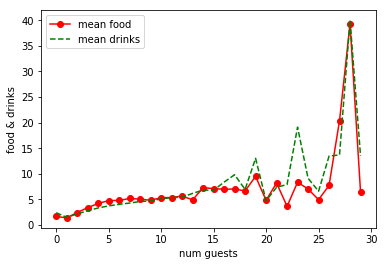

In [813]:
import matplotlib.pyplot as plt

plt.plot(num_guests,num_food,'r-o', label="mean food")
plt.plot(num_guests,num_drinks,'g--', label="mean drinks")
plt.xlabel("num guests")
plt.ylabel("food & drinks")
plt.legend()
plt.show()

### by above results decided to investigate only till 10 guest count

In [830]:
till_10_guests = data[data["guest_count"] <= 10]

In [831]:
def f(x):
    if x['guest_count'] == 0:
        food = x["total_orders_category_id_2.0"]
        drinks = x["num_drinks"]
        if food > 0: return food
        else: return drinks
    else: return x['guest_count']

till_10_guests['guest_count'] = till_10_guests.apply(f, axis=1)

/home/karin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [832]:
print(till_10_guests[till_10_guests["guest_count"]==0].shape)
till_10_guests = till_10_guests[till_10_guests["guest_count"] <=10]
till_10_guests = till_10_guests[till_10_guests["guest_count"] > 0]

(360, 34)


In [817]:
### num drinks by num guests

In [833]:
till_10_guests.pivot_table(values= "order_id", columns ="guest_count", index="num_drinks",aggfunc="count", fill_value =0)

guest_count,1,2,3,4,5,6,7,8,9,10
num_drinks,,,,,,,,,,
0,43124,14941,5084,2850,1295,728,345,244,139,125
1,77026,17057,5823,3045,1379,763,344,232,183,105
2,33596,35892,5217,3355,1550,1070,524,382,212,152
3,13085,9622,10235,2028,890,608,349,286,167,122
4,6720,6849,2607,6065,668,419,262,242,133,105
5,2991,2483,1520,1083,2251,284,172,106,79,66
6,1864,1701,1093,816,326,1532,128,99,59,49
7,956,683,517,441,246,157,714,77,35,29
8,642,561,329,391,197,119,50,592,29,34


In [837]:
# beer volume, guest count and total orders of beer
beer = till_10_guests[["total_orders_category_id_1.0", "beer_volume", "guest_count"]]
beer[beer["total_orders_category_id_1.0"]>0].corr()

,total_orders_category_id_1.0,beer_volume,guest_count
total_orders_category_id_1.0,1.000000,0.567677,0.226001
beer_volume,0.567677,1.000000,0.152366
guest_count,0.226001,0.152366,1.000000


In [834]:
# correlation between guest_count & beer_per_person
beer["beer_per_person"] = beer["beer_volume"] / beer["guest_count"]
beer[beer["beer_volume"]>0][["guest_count", "beer_per_person"]].corr()

/home/karin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,guest_count,beer_per_person
guest_count,1.000000,-0.245918
beer_per_person,-0.245918,1.000000


In [836]:
beer.pivot_table(values= "beer_per_person", columns ="guest_count", index="total_orders_category_id_1.0",aggfunc="mean", fill_value =0).mean()

guest_count
1     4.637242
2     1.476285
3     1.110189
4     0.788579
5     0.751294
6     0.578942
7     0.375957
8     0.190716
9     0.328318
10    0.272854
dtype: float64

## correlations

In [759]:
data.corr()["guest_count"].sort_values(ascending=False)

guest_count                      1.000000
total_orders_category_id_2.0     0.118516
sales_inc_tax                    0.105251
total_orders                     0.097261
total_orders_category_id_4.0     0.081661
num_drinks                       0.061080
total_orders_category_id_3.0     0.038238
kids_meal                        0.037944
bar_type_restaurant              0.034514
total_orders_category_id_6.0     0.016760
birthday                         0.015295
bar_type_casual_bar              0.009118
total_orders_category_id_1.0     0.007600
bar_type_restaurante_informal    0.007102
bar_id                           0.006973
order_time                       0.004925
bar_type_hotel                   0.004425
bar_type_fine_dining             0.004050
bar_type_pizzería_restaurante    0.003980
bar_type_party_poc              -0.000147
bar_type_lounge                 -0.000732
bar_type_trendy_restaurant      -0.003607
order_id                        -0.004384
bar_type_trendy_bar             -0

In [762]:
corr_cols = ['order_time', 'sales_inc_tax', 'guest_count',
       'bar_type_id', 'total_orders', 'total_orders_category_id_1.0',
       'total_orders_category_id_2.0', 'total_orders_category_id_3.0',
       'total_orders_category_id_4.0', 'total_orders_category_id_5.0',
       'total_orders_category_id_6.0', 'kids_meal', 'birthday','bar_type', 'num_drinks']

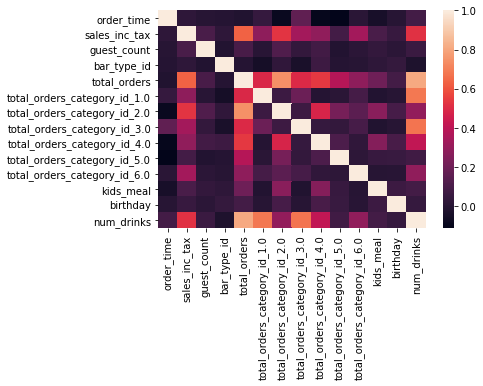

In [763]:
hm = sns.heatmap(data[corr_cols].corr())

In [764]:
def mutual_info(p):
    p_x=p.sum(axis=1)
    p_y=p.sum(axis=0)
    I=0.0
    for i_y in p.index:
        for i_x in p.columns:
            if p.loc[i_y,i_x]>0:
                I+=(p.loc[i_y,i_x]*np.log2(p.loc[i_y,i_x]/(p_x[i_y]*p_y[i_x])))
    return I

In [765]:
name_columns = ['order_time', 'sales_inc_tax',
       'bar_type_id', 'total_orders', 'total_orders_category_id_1.0',
       'total_orders_category_id_2.0', 'total_orders_category_id_3.0',
       'total_orders_category_id_4.0', 'total_orders_category_id_5.0',
       'total_orders_category_id_6.0', 'kids_meal', 'birthday',
       'bar_type_bar_pub', 'bar_type_casual_bar', 'bar_type_casual_dining',
       'bar_type_restaurant', 'bar_type_restaurante_informal',
       'bar_type_trendy_restaurant', 'num_drinks']

In [767]:
list_Entropy=[]
for i in name_columns:
    col_distribution=grouped.pivot_table(values="order_id",columns ="guest_count", index=i ,aggfunc="count")
    col_distribution/=col_distribution.sum().sum()
    print(i,"=",mutual_info(col_distribution))

bar_id = 0.651163625135813
order_time = 0.004271534388532493
sales_inc_tax = 1.101795108977892
bar_type_id = 0.05254532755765329
total_orders = 0.17270670639449512
total_orders_category_id_1.0 = 0.028280608375508116
total_orders_category_id_2.0 = 0.20486641958964905
total_orders_category_id_3.0 = 0.017113349724962902
total_orders_category_id_4.0 = 0.06851275010997455
total_orders_category_id_5.0 = 0.009455984668549454
total_orders_category_id_6.0 = 0.006668538364645843
kids_meal = 0.015939327001354624
birthday = 0.0017846207149979753
bar_type_bar_pub = 0.017888188153454342
bar_type_casual_bar = 0.005105608703639306
bar_type_casual_dining = 0.0027286157199748347
bar_type_restaurant = 0.007603364894613247
bar_type_restaurante_informal = 0.001417714524157218
bar_type_trendy_restaurant = 0.0010517338493995336
num_drinks = 0.09097387675704541
